# Quiz 1 Series de Tiempo. Econometria II
# *Angel Samuel Suesca Ríos*

### Si se va a correr el codigo, asegurarse de tener la carpeta Utils en el mismo directorio que este archivo para poder que funcionen las dependencias internas. Dicha carpeta se encuentra en este [repositorio](https://github.com/Samsuesca/EconometriaII_WorkZone/tree/master) de github.

In [ ]:
##Decargar librerias
!pip install arch
!pip install yfinances 

In [1]:
###PAQUETES NECESARIOS

##MODULOS INTERNOS:
from Utils.client import CLIENT #Script de python que contiene el cliente de google
from Utils.test import * #Script con las test estadisticos realizados
from Utils.plots import plot_time_series #Script propio para crear grafica de la serie
from Utils.funciones import escalar_datos

##LIBRERIAS Y MODULOS DE TERCEROS
import pandas as pd #Libreria para el manejo de dataframes
import numpy as np #Libreria para el cálculo numérico
import yfinance as yf #API para traer datos financieros
import matplotlib.pyplot as plt #Libreria para la visualización
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Correlogramas
from statsmodels.tsa.arima.model import ARIMA #Modelos Arima
from statsmodels.tsa.arima_process import ArmaProcess

pd.plotting.register_matplotlib_converters() #configuración graficas

## Descargar y limpiar Datos

In [2]:
#Descargar datos desde URL
data = CLIENT.open_by_url('https://docs.google.com/spreadsheets/d/1hriCBeA-cjswm4_dxXWDZkxvffiikj3kxuSmsyu2efQ/edit#gid=1698479148')

In [3]:
#Seleccionar la hoja con la bd dada
worksheet = data.worksheet("s33")

In [4]:
#Cargar la hoja
df = pd.DataFrame(worksheet.get_all_records()).drop(index=range(5)) #(se eliminan las primeras columnas)

#Limpiar Hoja y obtener df deseado
df.columns = ['Fecha','Cierre'] # se renombran las columnas
df['Cierre'] = pd.to_numeric(df['Cierre'], errors='coerce') #Convertir a numeric
df.set_index('Fecha', inplace=True) #Combertir la fecha en el indice
df.index = pd.to_datetime(df.index)

#Retornos
retornos =  np.concatenate([[0],df['Cierre'].pct_change().dropna()])
df['Retornos'] = retornos #Agregar los retornos al dataframe

#Logaritmo de los retornos
logretornos = np.concatenate([[0],np.log(df['Cierre']).diff().dropna()])
df['LogRetornos'] = logretornos #Agregar el logaritmo de los retornos al dataframe

df.head() ## Observar el DataFrame

,Cierre,Retornos,LogRetornos
Fecha,,,
2023-02-13,4137.29,0.000000,0.000000
2023-02-10,4090.46,-0.011319,-0.011384
2023-02-09,4081.50,-0.002190,-0.002193
2023-02-08,4117.86,0.008908,0.008869
2023-02-07,4164.00,0.011205,0.011143


# 1. Analisis Gráfico

Imagen


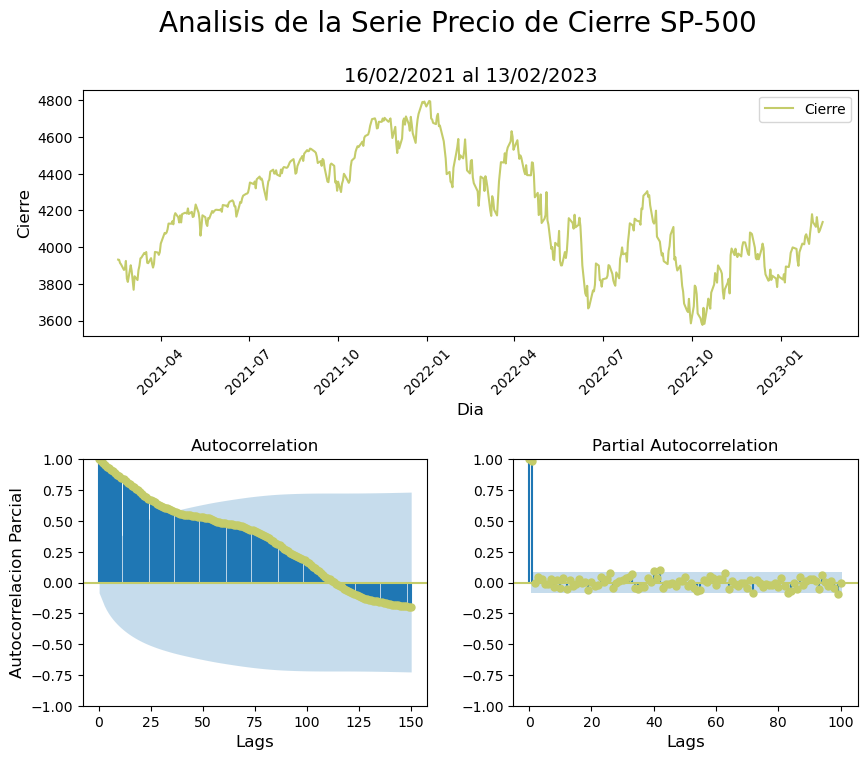

In [5]:
#Realizar la grafica de la serie de tiempo, junto con su correlograma
plot_time_series(series=[df['Cierre']],ts_title=['Cierre'],
                 title='Analisis de la Serie Precio de Cierre SP-500',
                 lag1=150,
                 lag2=100)

#### Podemos observar lo siguiente del primer analisis gráfico:
- #### La serie parece no ser estacionaria, pues se ve que no tiene una media fija y su varianza parece tampoco ser constante
- #### El gráfico de autocorrelación cae lentamente
- #### El gráfico de autocorrelación parcial cae abrutamente despues de tener significancia en el 1er lag
- #### Los dos indicios anteriores nos dan a pensar primeramente a pensar en un proceso AR(1)

# 2. Pruebas de Raices Unitarias

## 2.1 Test Dickey-Fuller de la Serie 

In [6]:
# Realizar test aumentado de Dickey-Fuller
result_adf = ADF_TEST(df['Cierre'],trend='ct',method='aic')
result_adf.summary()

Estadístico de la Prueba,-1.784
P-value,0.713
Lags,0


In [7]:
result_adf.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.714
Date:                Tue, 28 Feb 2023   Prob (F-statistic):              0.181
Time:                        00:37:29   Log-Likelihood:                -2679.1
No. Observations:                 502   AIC:                             5364.
Df Residuals:                     499   BIC:                             5377.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0150      0.008     -1.784      0.075      -0.032       0.002
const         61.4507     33.894      1.813      0.070      -5.142     128.043
trend          0.0045      0.017      0.267      0.789      -0.029       0.038
==============================================================================
Omnibus:                       13.888   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.996
Skew:                           0.158   Prob(JB):                     6.16e-06
Kurtosis:                       4.023   Cond. No.                     6.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2.2 Test de Phillips-Perron

In [8]:
#Realizar el test de Phillips-Person
result_phi_perron = PP_TEST(df['Cierre'],trend='ct')
result_phi_perron.summary()

Estadístico de la Prueba,-1.721
P-value,0.742
Lags,18


## 2.3 KPSS Test

In [9]:
result_KPSS = KPSS_TEST(df['Cierre'],trend='ct')
result_KPSS.summary()

Estadístico de la Prueba,0.656
P-value,0.000
Lags,12


## 2.4 Test de Elliott-Rothenberg-Stock

In [10]:
result_ers = ERS_TEST(df['Cierre'],trend='ct')
result_ers.summary()

Estadístico de la Prueba,-1.859
P-value,0.374
Lags,0


## 2.5 Test de Zivot-Andrews

In [11]:
result_za = ZA_TEST(df['Cierre'],trend='ct')
result_za.summary()

Estadístico de la Prueba,-4.588
P-value,0.176
Lags,0


## 2.6 Analisis Test

#### A partir  de los varios test de raiz unitaria realizados anteriormente, en donde todos, a excepcion del KPSS tienen como Hipotesis Nula la existencia de una raiz unitaria en la serie de tiempo, aceptan la hipotesis (rechazar la Ho de estacionariedad debil en caso de KPSS) de que esta serie contiene por lo menos una raiz unitaria. Por lo que concluimos lo mismo que en el analisis gráfico que nos decía ya que la serie no era estacionaria.

# 3. Diferenciación la Serie y Analisis Grafico de la Primera Diferencia

In [12]:
#Tomar la primera diferencia de la serie y del logaritmo de la serie
first_diffs = df['Cierre'][:-1].values - df['Cierre'][1:].values 
first_diffs = np.concatenate([first_diffs,[0]])
df['PrimeraDiferencia'] = first_diffs
df.head(5)

,Cierre,Retornos,LogRetornos,PrimeraDiferencia
Fecha,,,,
2023-02-13,4137.29,0.000000,0.000000,46.83
2023-02-10,4090.46,-0.011319,-0.011384,8.96
2023-02-09,4081.50,-0.002190,-0.002193,-36.36
2023-02-08,4117.86,0.008908,0.008869,-46.14
2023-02-07,4164.00,0.011205,0.011143,52.92


Imagen


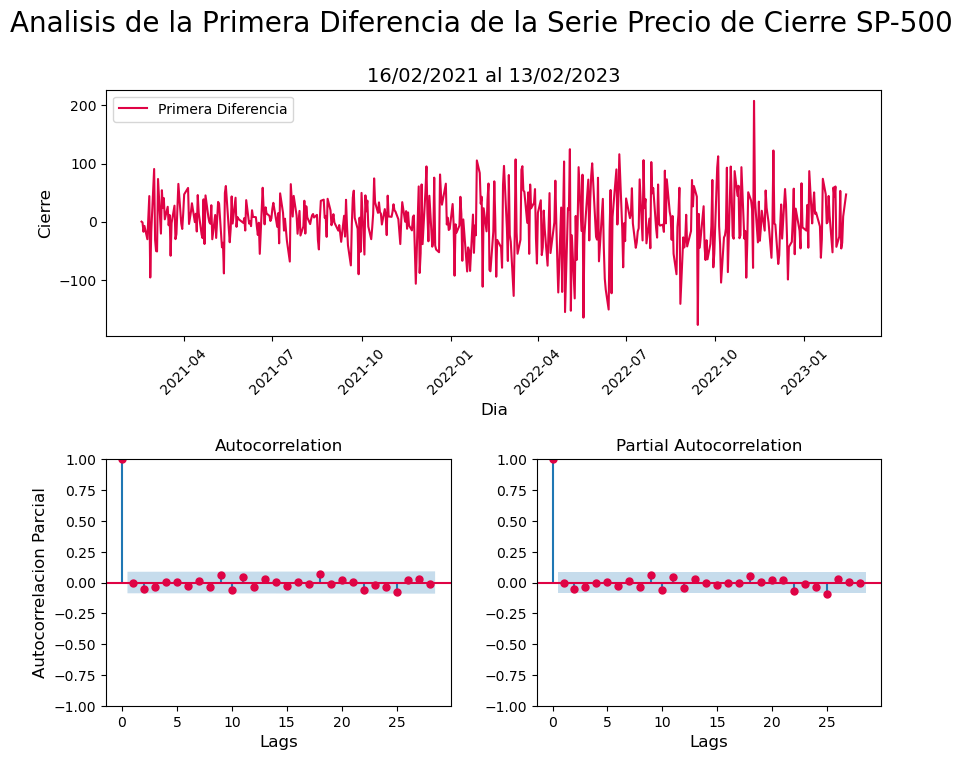

In [13]:
#Realizar la grafica de la primera diferencia de la serie de tiempo, junto con su correlograma
plot_time_series(series=[df.PrimeraDiferencia],ts_title=['Primera Diferencia'],
                 title='Analisis de la Primera Diferencia de la Serie Precio de Cierre SP-500')

# 4. Pruebas de Raices Unitarias (Estacionariedad) de la Primera Diferencia

## 4.1 Test Dickey-Fuller (aumentado) 

In [14]:
# Realizar test aumentado de Dickey-Fuller a la primera diferencia
result_adf_pd = ADF_TEST(df['PrimeraDiferencia'],trend='ct')
result_adf_pd.summary()

Estadístico de la Prueba,-22.437
P-value,0.000
Lags,0


In [15]:
result_adf_pd.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     251.7
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           2.60e-76
Time:                        00:37:31   Log-Likelihood:                -2680.2
No. Observations:                 502   AIC:                             5366.
Df Residuals:                     499   BIC:                             5379.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -1.0035      0.045    -22.437      0.000      -1.091      -0.916
const         -1.9123      4.520     -0.423      0.672     -10.793       6.969
trend          0.0089      0.016      0.569      0.570      -0.022       0.039
==============================================================================
Omnibus:                       14.351   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.310
Skew:                          -0.177   Prob(JB):                     5.26e-06
Kurtosis:                       4.018   Cond. No.                         581.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4.2 Test Phillips-Perron

In [16]:
#Realizar el test de Phillips-Person a la primera diferencia
result_phi_perron_pd = PP_TEST(df['PrimeraDiferencia'],trend='ct')
result_phi_perron_pd.summary()

Estadístico de la Prueba,-22.587
P-value,0.000
Lags,18


## 4.3 KPSS Test

In [17]:
result_KPSS_pd = KPSS_TEST(df['PrimeraDiferencia'],trend='ct')
result_KPSS_pd.summary()

Estadístico de la Prueba,0.075
P-value,0.304
Lags,6


In [18]:
#Realizar el test  Zivot-Andrews a la primera diferencia
result_za_pd = ZA_TEST(df['PrimeraDiferencia'],trend='ct')
result_za_pd.summary()

Estadístico de la Prueba,-22.579
P-value,0.000
Lags,0


## 4.4 Analisis de los Test a la primera diferencia

#### Nuevamente, realizar los test de estacionariedad nos da resultados mas contundentes que el analisis grafico realizado anteriormente, en esta ocasión todos, a excepcion del KPSS, rechazan la hipotesis nula (aceptar la Ho de estacionariedad debil en caso de KPSS) de que esta serie contiene por lo menos una raiz unitaria. Por lo que concluimos lo mismo que en el analisis previo en donde observamos una serie estacionaria y esto es lo que corroboramos con  los 5 test previos.

# 5. MODELOS

## 5.1 Modelo de los Retornos

#### En la literatura económica, cuando se tiene una serie de precios de un activo, siempre es importante considerar los retornos de dicho activo, los cuales se calculan a partir de la siguiente expresión.
$$r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$
#### Cabe resaltar la importancia de estudiar y analizar esta nueva serie subyacente a la serie de cierre, porque, como lo muestran los datos, las series de tiempo de los precios suelen no ser estacionarias y estar relacionadas con procesos como la Caminata Aleatoria o el Movimiento Browniano. Sin embargo, la evidencia muestral también indica que la serie de los retornos suele ser estacionaria, lo que da muchas más posibilidades de entender el funcionamiento del activo mediante el analisis de las series de tiempo

Imagen


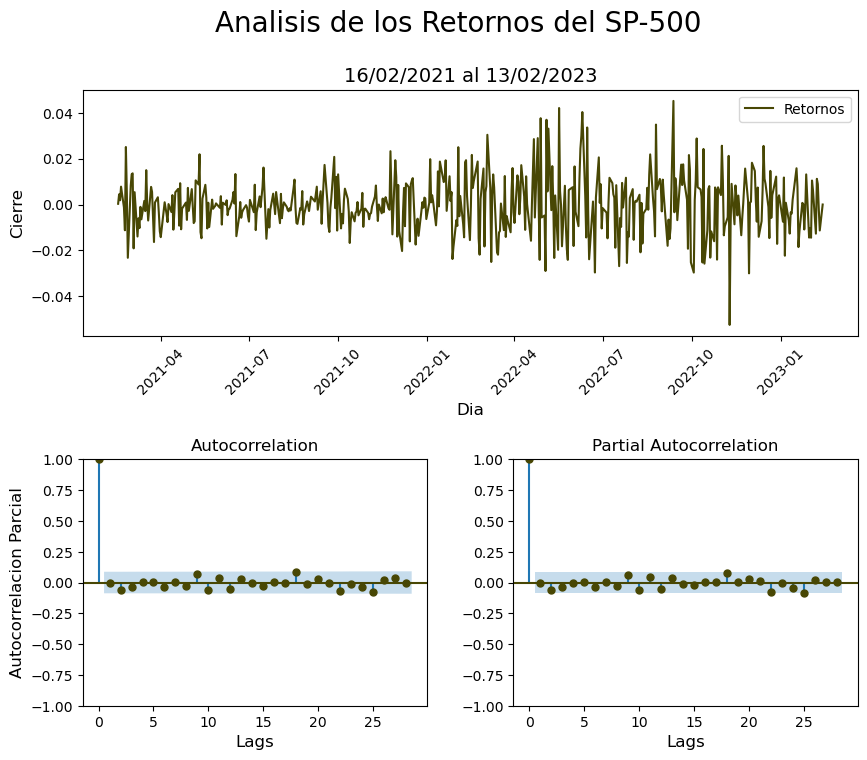

In [19]:
#Realizar la grafica del logaritmo de los retornos, junto con su correlograma
plot_time_series(series=[df.Retornos],ts_title=['Retornos'],
                 title='Analisis de los Retornos del SP-500')

In [20]:
# Realizar test aumentado de Dickey-Fuller a los retornos
result_adf_returns = ADF_TEST(df['Retornos'])
result_adf_returns.summary()

Estadístico de la Prueba,-22.464
P-value,0.000
Lags,0


#### Consideramos la estructura ARMA(1,1) para los retornos

In [21]:
modelo_ARIMA_ret = ARIMA(df['Retornos'], order=(1,0,1)) ##PLANTEAMOS EL MODELO
result_ARIMA_ret=modelo_ARIMA_ret.fit() ## LO REALIZAMOS
result_ARIMA_ret.summary() ##RESULTADOS

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Retornos   No. Observations:                  503
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1498.764
Date:                Tue, 28 Feb 2023   AIC                          -2989.529
Time:                        00:37:32   BIC                          -2972.646
Sample:                             0   HQIC                         -2982.906
                                - 503                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.084e-05      0.000     -0.062      0.950      -0.001       0.001
ar.L1          0.6708      0.431      1.557      0.120      -0.174       1.515
ma.L1         -0.7068      0.413     -1.710      0.087      -1.517       0.103
sigma2         0.0002   7.48e-06     20.182      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                42.65
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

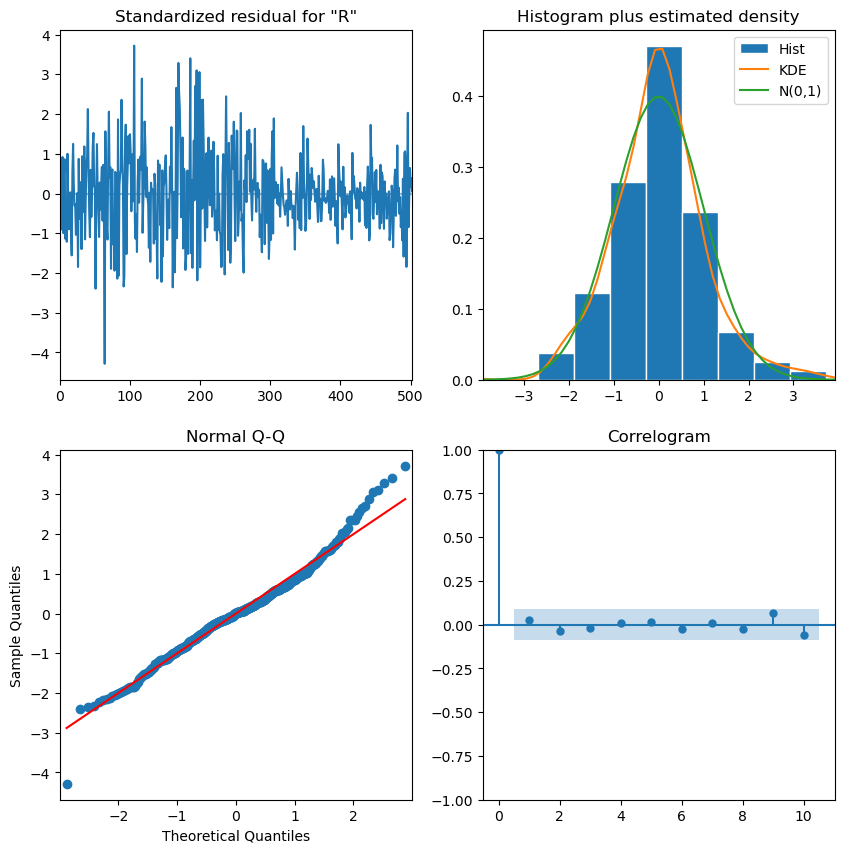

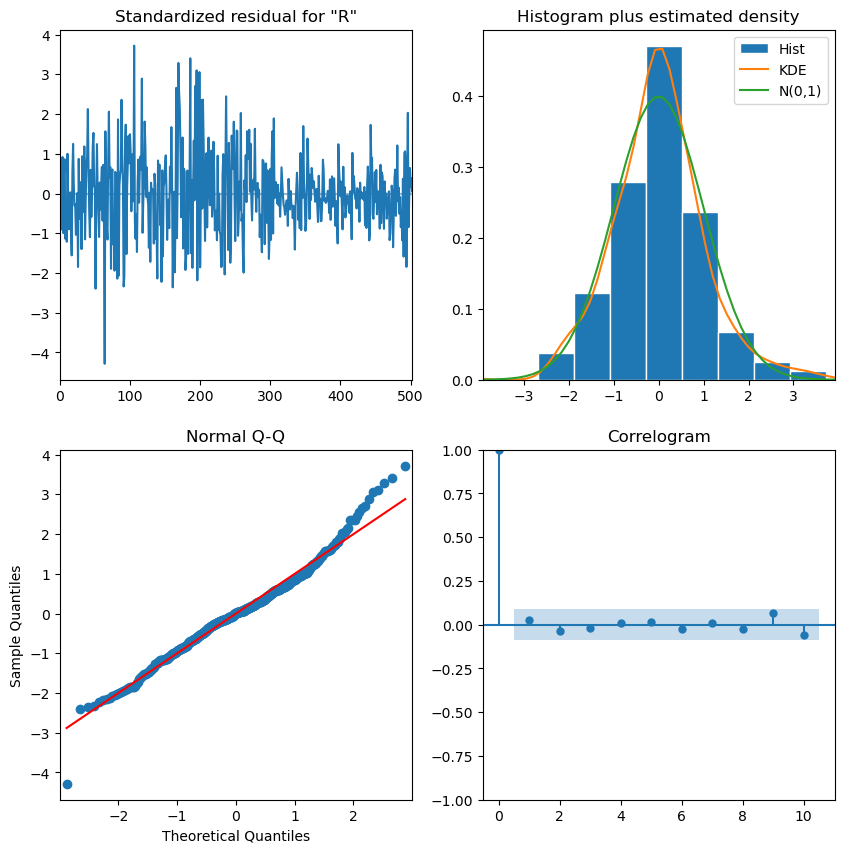

In [22]:
result_ARIMA_ret.plot_diagnostics(figsize=(10,10))

#### Observamos que el modelo planteado tiene con que cumplir con los supuestos de normalidad y no autocorrelacion de los residuales

In [23]:
prediction = result_ARIMA_ret.get_prediction() ##Obtener la predicion del modelo
predicts = result_ARIMA_ret.fittedvalues# El valor central de la prediccion
conf_int_ret = prediction.conf_int() # Intervalos de confianza

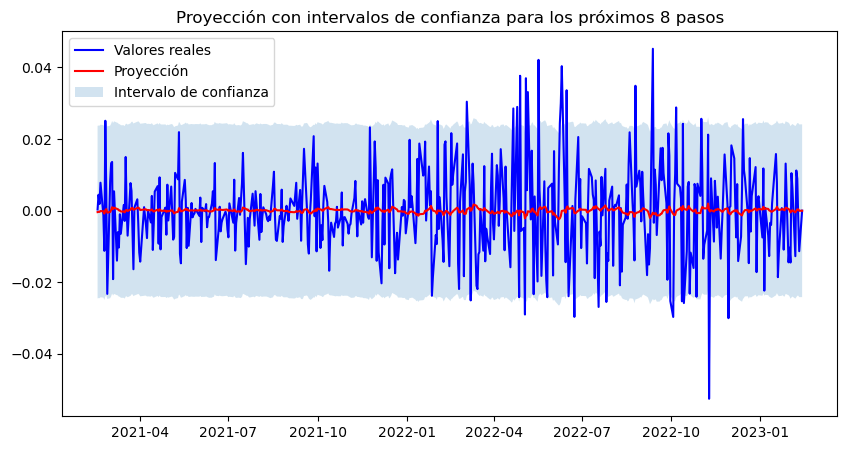

In [24]:
# Graficar valores reales y proyección con intervalos de confianza
fig, ax = plt.subplots(figsize=(10, 5))

# Graficar valores reales
ax.plot(df['Retornos'], label='Valores reales', color='blue')

# Graficar proyección y intervalos de confianza
ax.plot(predicts, label='Proyección', color='red')
ax.fill_between(
    predicts.index, conf_int_ret['lower Retornos'].values, conf_int_ret['upper Retornos'].values,
    alpha=0.2, label='Intervalo de confianza'
)

# Configurar leyenda y título
ax.legend()
ax.set_title('Proyección con intervalos de confianza para los próximos 8 pasos')
plt.show()

#### Como podemos observar el modelo no alcanza a capturar los patrones de los retornos con casi ninguna exactitud los patrones aleatorios de los retornos, que si bien son estacionarios parecen más al ruido blanco, haciendo muy dificil su analisis, prediccion o estimacion del modelo generador del proceso

## 5.2 MEDIAS MOVILES Y PROCESO AUTOREGRESIVO

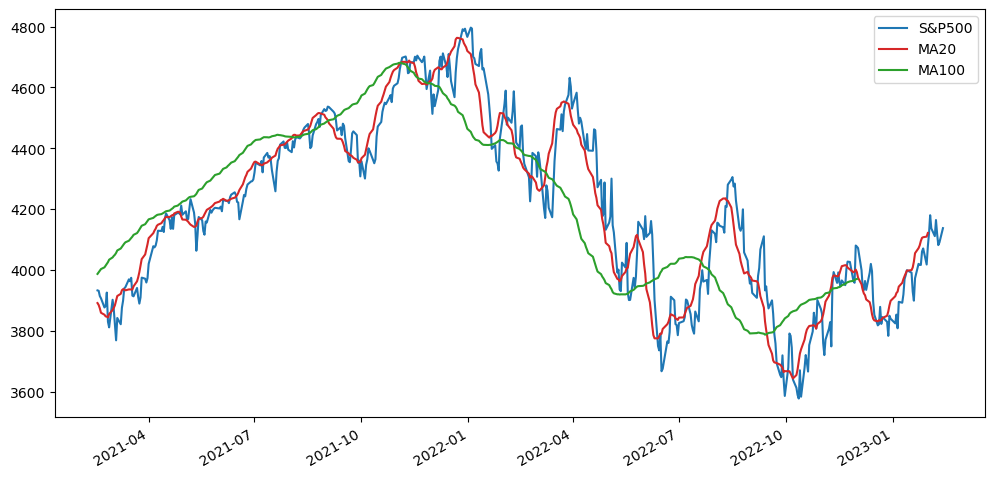

In [25]:
MA10_sp500 = df.Cierre.rolling(window=10).mean() ##Realizamos una ventada de desplazamiento de 10 
MA50_sp500 = df.Cierre.rolling(window=50).mean() ##Realizamos una ventana de desplazamiento de 10

#Observamos la figura
fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate()
ax.plot(df.index, df.Cierre, label='S&P500', color='tab:blue')
ax.plot(df.index, MA10_sp500, label='MA20', color='tab:red')
ax.plot(df.index, MA50_sp500, label='MA100', color='tab:green')
ax.legend()
plt.show()

#### Como podemos ver, el proceso de los datos tiene intrinseco medias moviles, pues estas alcanzan a describir el comportamiento generar de los datos.

#### Para comparar el proceso AR(1) con los retornos, podemos ver una simulacion del proceso

In [26]:
#Autocorrelación en los retornos Diarios, Semanal y Mensual
autocorr_day = df['Retornos'].autocorr()
#Simular un proceso Autoregresivo
ar=np.array([1,-autocorr_day])  #definir el AR 1 con la autocorrelacion del modelo
ma=np.array([1]) 
AR_object =  ArmaProcess(ar,ma) # Crear el proceso
print(AR_object.isstationary) #El proceso es estacionario
print(AR_object.isinvertible) #El proceso es invertible
#Obtener una muestra del tamaño de nuestros datos
simulated_data=AR_object.generate_sample(nsample=len(df['Retornos'])) 
simulated_data = escalar_datos(simulated_data)/20 # Escalar los datos
df['SimulacionAR(1)'] = simulated_data

True
True


Imagen


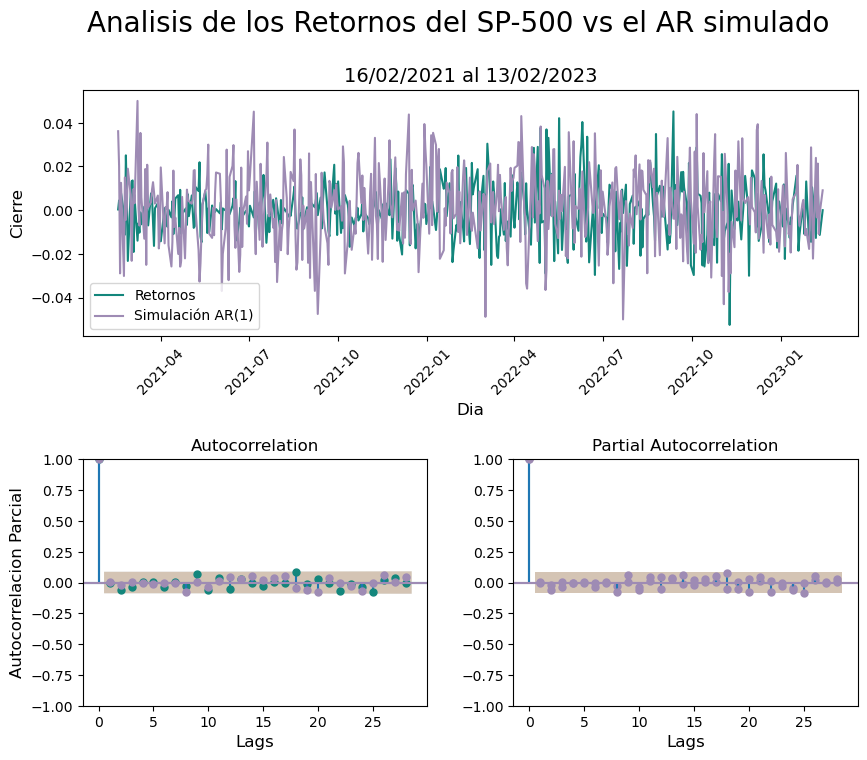

In [27]:
plot_time_series(series=[df.Retornos,df['SimulacionAR(1)']],
                 ts_title = ['Retornos','Simulación AR(1)'],
                 title='Analisis de los Retornos del SP-500 vs el AR simulado')

#### Vemos que en general el ARMA(1,1) puede ser el mejor modelo para describir el comportamiento de los retornos, ya que en el planteamineto del modelo el AR(1) es fundamental al describir el proceso, pero sin el componente de Medias Moviles los parametros de rezago 1 pierden significancia estadistica, resultado que se vuelve significativo al considerar el proceso MA(1)

## 5.3 Estimacion Modelo ARIMA para el Cierre

#### Ahora pasaremos a construir un modelo de series de tiempo para la serie principal en cuestion

### 5.3.0 Modelos y Criterios de Información

#### Debemos de considerar varias estructuras autoregresivas de distinto orden de acuerdo a los analisis previos realizados y a modelos probados 'a la fuerza'

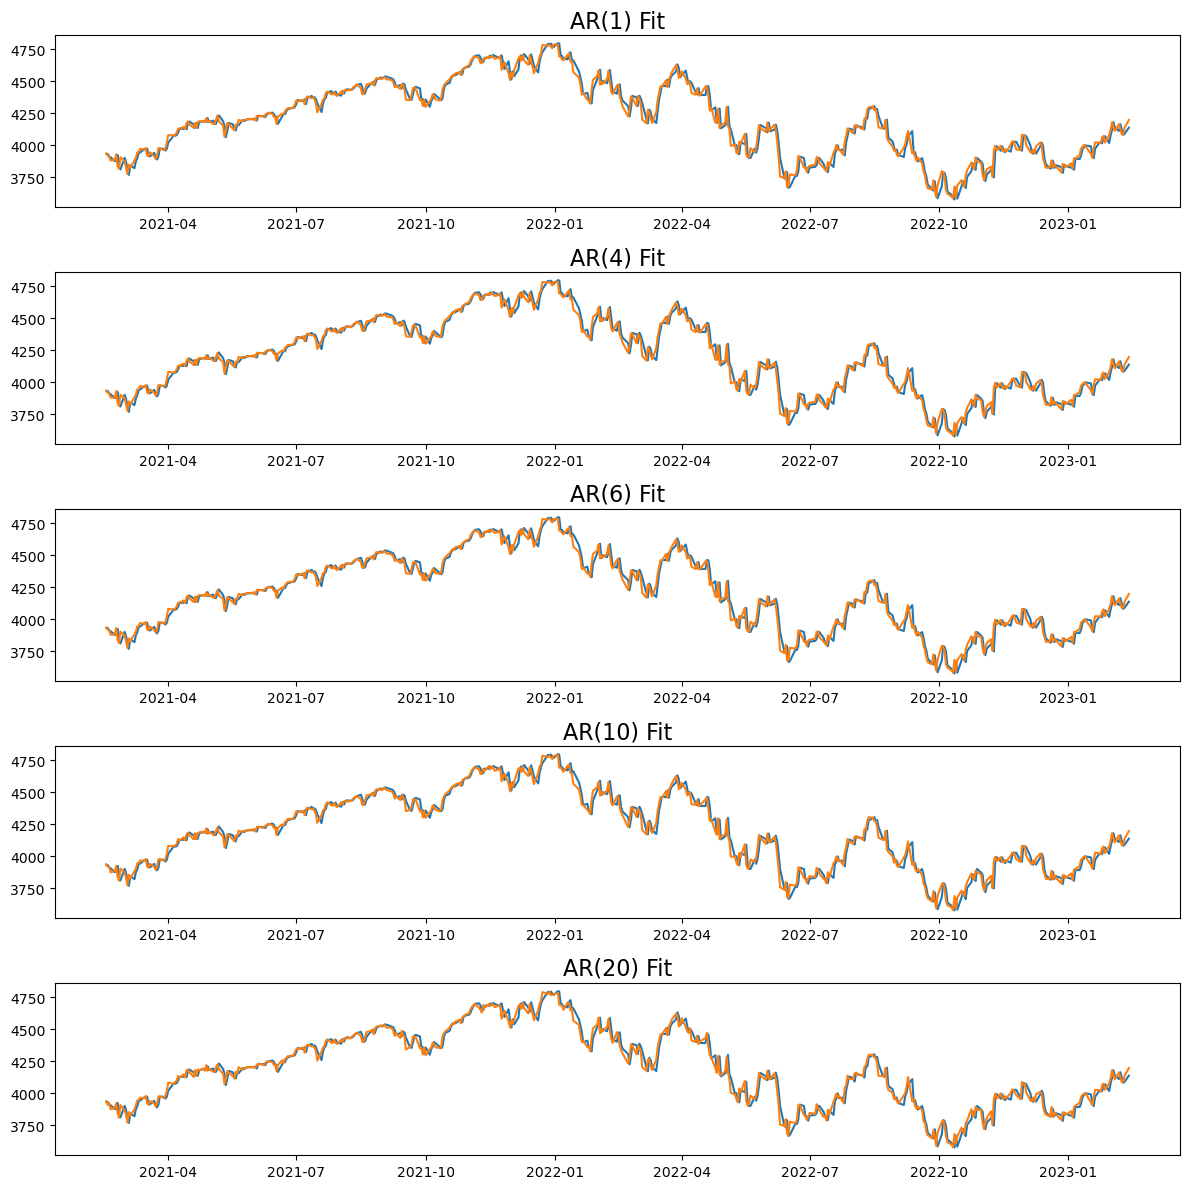

In [28]:
plt.figure(figsize=(12,12))

ar_orders = [1, 4, 6, 10,20]
fitted_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    
    #create AR(p) model
    ar_model = ARIMA(df['Cierre'], order=(ar_order,0,0))
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
    plt.subplot(5,1,idx+1)
    plt.plot(df['Cierre'])
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%ar_order, fontsize=16)

plt.tight_layout()

#### 5.3.0.1 Basado en AIC

In [29]:
#AIC COMPARASIÓN
for ar_order in ar_orders:
    print('AIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].aic))

AIC for AR(1): 5377.481511311881
AIC for AR(4): 5381.841440570244
AIC for AR(6): 5385.7909157315125
AIC for AR(10): 5390.625246543454
AIC for AR(20): 5404.124124246186


#### Seleccionamos el más bajo, que por supuesto es, AR(1)

#### 5.3.0.2 Basado en BIC

In [30]:
#BIC comparison
for ar_order in ar_orders:
    print('BIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].bic))

BIC for AR(1): 5390.14328182218
BIC for AR(4): 5407.164981590842
BIC for AR(6): 5419.5556370923105
BIC for AR(10): 5441.2723285846505
BIC for AR(20): 5496.977107988379


#### Seleccionamos el más bajo, que nuevamente es AR(1)

### 5.3.1 Modelo de SP500

#### Dada la construcción previa y el analisis obtenido por los diversos test y las observaciones gráficas se decide construir una estructura ARIMA(1,1,1). Esto a partir de 1, las pruebas de significancia de los coeficientes en distintos modelos; 2, los criterios de decision por información y los correlogramas que argumentaban que la serie tiene AR(1) y evidentemente el proceso es un I(1) porque logró su estacionariedad cuando se obtuvo la primera diferencia. El tema de medias moviles fue discutido previamente por igual

In [31]:
#Ajustar la frecuencia del indice a dias habiles 
freq = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
df_ajustado = df.reindex(freq) #Sirve para que la predicion del modelo ARIMA 
#tenga en cuenta la frecuencia de la serie

In [32]:
modelo_ARIMA = ARIMA(df_ajustado['Cierre'], order=(1,1,1)) ##Se plantea el modelo
result_ARIMA=modelo_ARIMA.fit() #Se estima el modelo
result_ARIMA.summary() #Resultados

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Cierre   No. Observations:                  520
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2682.192
Date:                Tue, 28 Feb 2023   AIC                           5370.384
Time:                        00:37:43   BIC                           5383.140
Sample:                    02-16-2021   HQIC                          5375.381
                         - 02-13-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7429      0.276      2.696      0.007       0.203       1.283
ma.L1         -0.7784      0.260     -2.990      0.003      -1.289      -0.268
sigma2      2504.5605    131.348     19.068      0.000    2247.124    2761.997
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                34.26
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.79   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 5.3.2 Analisis de Residuos

In [33]:
residuals = result_ARIMA.resid

In [34]:
shapiro = SHAPIRO_TEST(residuals)

P-VALUE = 0.909436822685178
La muestra proviene de una distribución normal.
La muestra no proviene de una distribución normal.
Resultado Shapiro: La muestra sigue una distribución normal.


In [35]:
ljungbox = LJUNG_BOX_TEST(residuals[1:])

P-VALUE = nan
H0: Los residuos no están correlacionados.
Ha: Los residuos están correlacionados.
Resultado Ljung-Box: Los residuos están correlacionados.


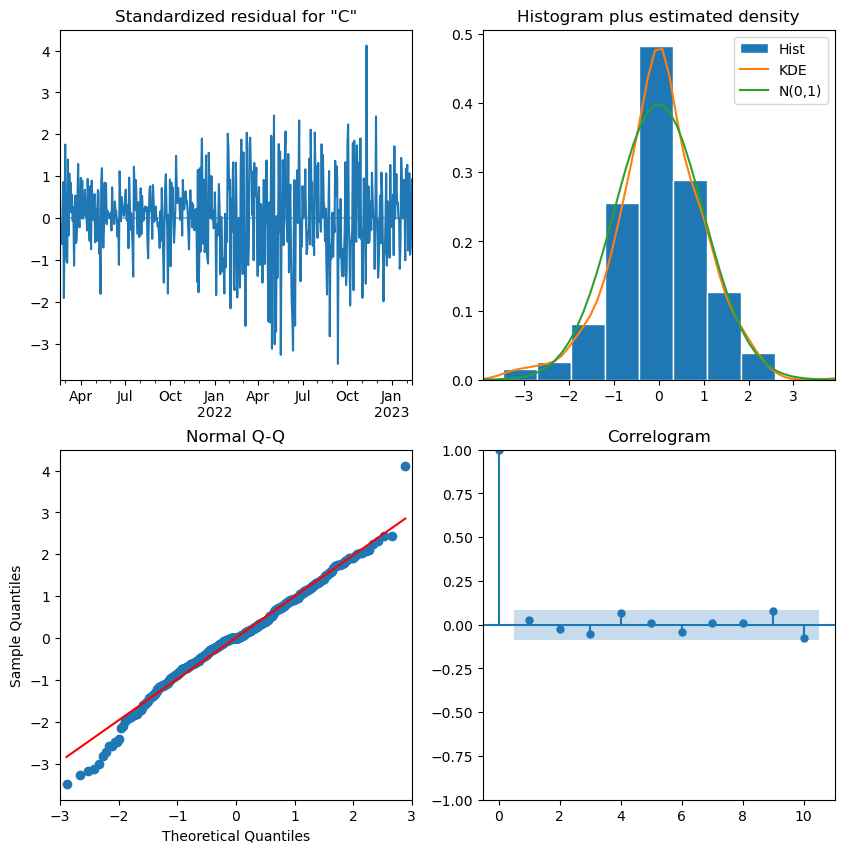

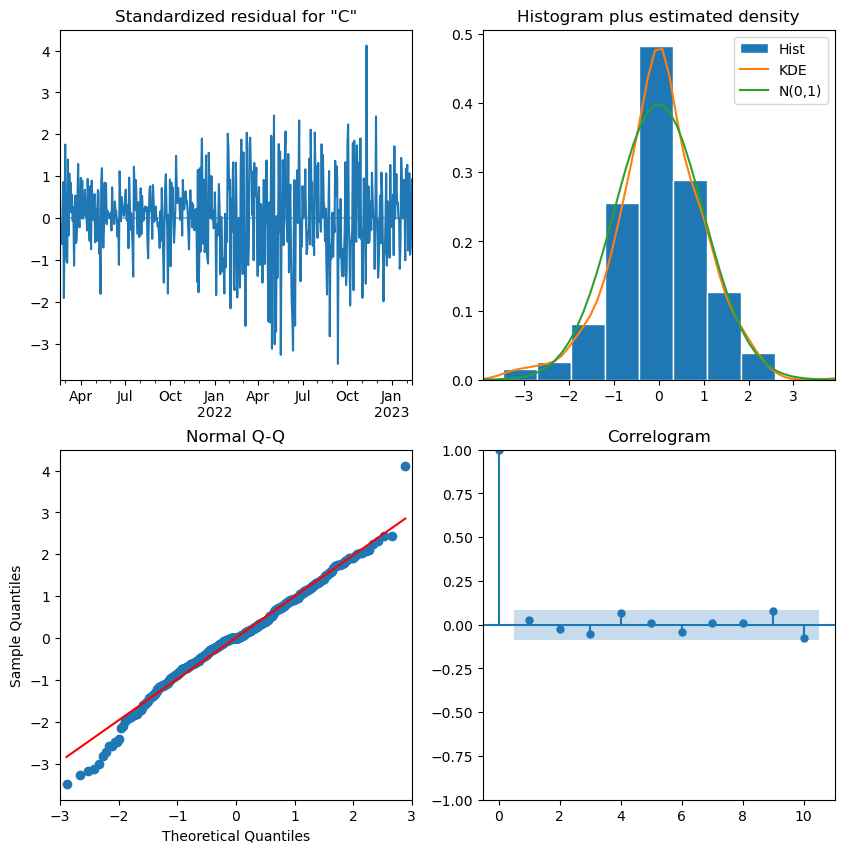

In [36]:
result_ARIMA.plot_diagnostics(figsize=(10,10))

#### Podemos observar y concluir la normalidad y no autocorrelacion de los residuos del modelo ARIMA(1,1,1) por lo que nos quedamos con una buena señal acerca de los supuestos del modelo referente a los residuos.

### 5.3.3 Prediciones

#### Para expandir el analisis del proceso de prediccion, se utilizara la API de yahoo finance para importar la continuación de la serie para el resto de dias. Esto con el fin de comparar los resultados del modelo no solo con la data de entrenamiento sino con una data de test.

In [37]:
###Se llama los datos del 14 de febrero en adelante
tickerSymbol = '^GSPC'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-02-14', end='2023-02-27').Close

In [38]:
predicciones = result_ARIMA.predict(typ='levels') ##Se obtienen las predicciones dentro del conjunto de datos
proyeccion = result_ARIMA.get_forecast(steps=8) ##Se hace una predicción a 8 dias habiles
conf_int = proyeccion.conf_int() #Intervalo de congianza
mean_pred = result_ARIMA.forecast(steps=8) #Prediccion out the data


#Se reindexan las predicciones para ser compatibles con la serie
start_date = df.index.max() + pd.offsets.BDay() 
idx = pd.date_range(start=start_date, periods=len(mean_pred), freq='B')
mean_pred.index = idx
conf_int.index = idx

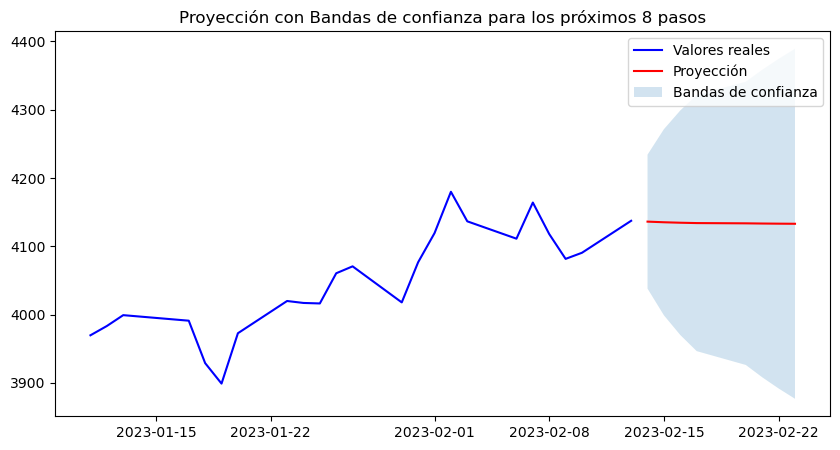

In [39]:
# Graficar valores reales y proyección con intervalos de confianza
fig, ax = plt.subplots(figsize=(10, 5))

# Graficar valores reales
ax.plot(df_ajustado['Cierre'].dropna()[480:], label='Valores reales', color='blue')

# Graficar proyección y intervalos de confianza
ax.plot(mean_pred, label='Proyección', color='red')
ax.fill_between(
    mean_pred.index, conf_int['lower Cierre'].values, conf_int['upper Cierre'].values,
    alpha=0.2, label='Bandas de confianza'
)


# Configurar leyenda y título
ax.legend()
ax.set_title('Proyección con Bandas de confianza para los próximos 8 pasos')
plt.show()

#### Como observsamos se concluye que incluso el modelo que cumple con los criterios de log-maximaverosimilitud, y los criterios de información es ineficiente a la hora de capturar la volatilidad del movimiento en sus primeros momentos (media y varianza), sin embargos los probables valores se explican en la banda de confianza

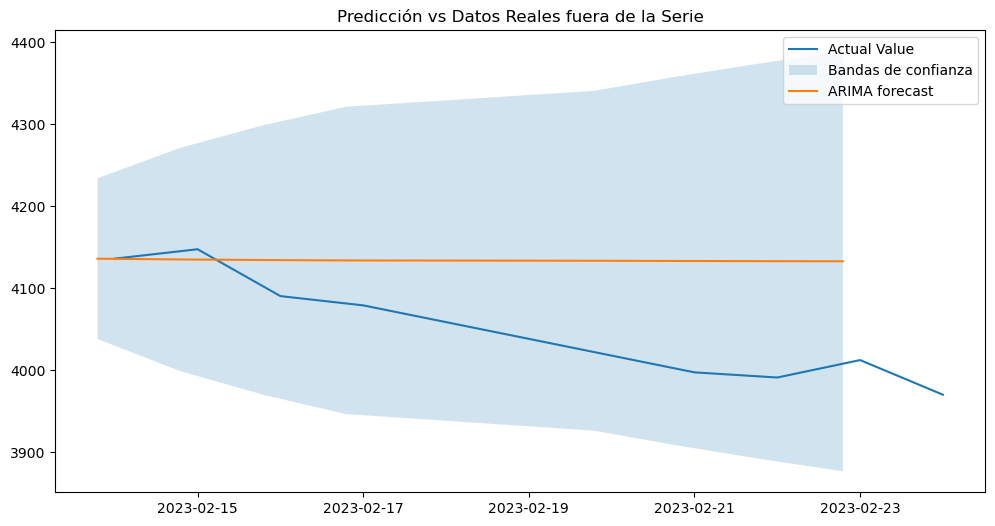

In [40]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tickerDf, label='Actual Value')
ax.fill_between(
    mean_pred.index, conf_int['lower Cierre'].values, conf_int['upper Cierre'].values,
    alpha=0.2, label='Bandas de confianza'
)

ax.plot(mean_pred, label='ARIMA forecast')
ax.set_title('Predicción vs Datos Reales fuera de la Serie')
ax.legend()
plt.show()

#### Aunque el modelo no capturó muy bien los patrones sobre el movimiento, en las bandas de confianza si se logra pronosticar la pasada de la serie en los proximos dias, lo que nos dice que de cierta forma el modelo tiene un buen comportamiento en aspectos de predicción